In [1]:
import os
import random
import shutil
import seaborn as sns
import tensorflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,load_model,Model
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras import backend as K
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.initializers import glorot_uniform
from keras.optimizers import SGD

In [2]:
path_train="/kaggle/input/train-test-valid/train"
path_valid="/kaggle/input/train-test-valid/valid"
path_test="/kaggle/input/train-test-valid/test"

Number of images of Powdery Mildew: 28
Number of images of Diseased Fruit: 40
Number of images of Healthy: 188
Number of images of Healthy Fruit: 93
Number of images of Cercospora leaf spot: 210


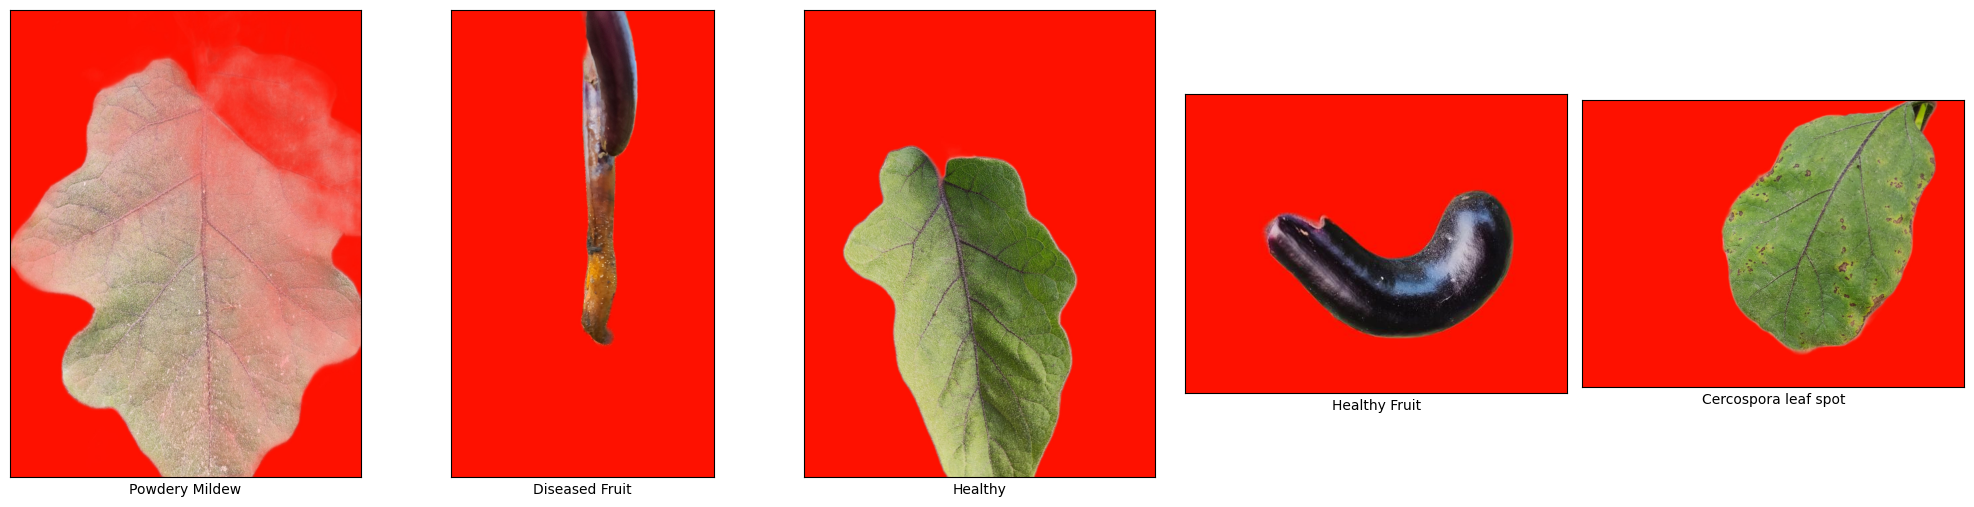

In [3]:
path =path_train
plt.figure(figsize=(20, 10))

count = 0
classes = []
total_images = 0

for i in os.listdir(path):
    count += 1
    classes.append(i)
    plt.subplot(2, 5, count)

    images_path = os.listdir(path + "/" + i)
    print("Number of images of " + i + ":", len(images_path))
    total_images += len(images_path)

    image_show = plt.imread(path + "/" + i + "/" + images_path[0])

    plt.imshow(image_show)
    plt.xlabel(i)

    plt.xticks([])
    plt.yticks([])


plt.tight_layout()
plt.show()

In [4]:
print(classes)
print(len(classes))
n_classes=len(classes)

['Powdery Mildew', 'Diseased Fruit', 'Healthy', 'Healthy Fruit', 'Cercospora leaf spot']
5


In [5]:
train_datagen= ImageDataGenerator(shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest',
                                  width_shift_range=0.2,
                                  height_shift_range=0.2)

val_datagen=ImageDataGenerator()

train= train_datagen.flow_from_directory(directory=path_train,
                                         batch_size=32,
                                         target_size=(224,224),
                                         color_mode='rgb',
                                         class_mode='categorical',
                                         seed=42)

valid=val_datagen.flow_from_directory(directory=path_valid,
                                      batch_size=32,
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      class_mode='categorical')

Found 559 images belonging to 5 classes.
Found 68 images belonging to 5 classes.


In [6]:
test_datagen = ImageDataGenerator()
test = test_datagen.flow_from_directory(
    directory=path_test,
    batch_size=32,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

# Get the class labels from the generator
class_labels = list(test.class_indices.keys())

Found 75 images belonging to 5 classes.


In [7]:
class_labels

['Cercospora leaf spot',
 'Diseased Fruit',
 'Healthy',
 'Healthy Fruit',
 'Powdery Mildew']

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [9]:
resNet50_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=classes)

94765736/94765736 [==============================] - 1s 0us/step


In [10]:
#Model building
resNet50_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
base_model=resNet50_model_tf(x,training=False)
base_model=GlobalAveragePooling2D()(base_model)
base_model=Dense(512,activation='relu')(base_model)
base_model=Dense(128,activation='relu')(base_model)
base_model=Dense(64,activation='relu')(base_model)
base_model=Dense(n_classes,activation='softmax')(base_model)


model_resNet50=Model(inputs=pt,outputs=base_model)
model_resNet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [11]:
!mkdir resnet50

In [12]:
# !rm -r resnet50

In [13]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=7, mode='auto')
mc = ModelCheckpoint(filepath='/kaggle/working/resnet50', monitor='val_accuracy', verbose=1, save_best_only=True)
lr = ReduceLROnPlateau(monitor='val_accuracy', verbose=1, patience=5, min_lr=0.001)

In [14]:
model_resNet50.compile(optimizer='Adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [15]:
history = model_resNet50.fit(train,
                 validation_data=valid,
                 epochs=30,
                 steps_per_epoch=10,
                 callbacks=[es, mc, lr],
                 verbose=1)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 0.9343 - accuracy: 0.6344
Epoch 1: val_accuracy improved from -inf to 0.83824, saving model to /kaggle/working/resnet50
10/10 [==============================] - 99s 10s/step - loss: 0.9343 - accuracy: 0.6344 - val_loss: 0.4679 - val_accuracy: 0.8382 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.8281
Epoch 2: val_accuracy did not improve from 0.83824
10/10 [==============================] - 57s 6s/step - loss: 0.4436 - accuracy: 0.8281 - val_loss: 0.6236 - val_accuracy: 0.7941 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.9043
Epoch 3: val_accuracy improved from 0.83824 to 0.88235, saving model to /kaggle/working/resnet50
10/10 [==============================] - 85s 9s/step - loss: 0.3276 - accuracy: 0.9043 - val_loss: 0.4861 - val_accuracy: 0.8824 - lr: 0.0010
Epoch 4/30
10/10 [==============================]

In [16]:
scores = model_resNet50.evaluate(test)

3/3 [==============================] - 10s 2s/step - loss: 0.3527 - accuracy: 0.9200


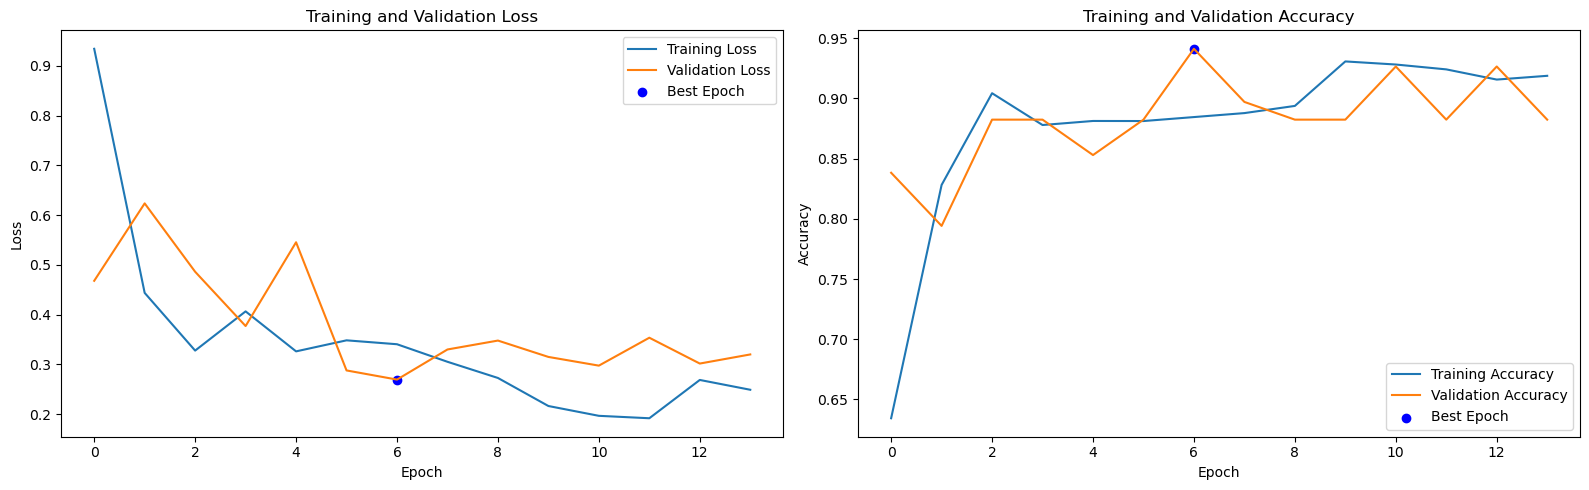

In [17]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# best epoch based on validation loss
best_epoch = np.argmin(val_loss)

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.scatter(best_epoch, val_loss[best_epoch], color='blue', label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.scatter(best_epoch, val_acc[best_epoch], color='blue', label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

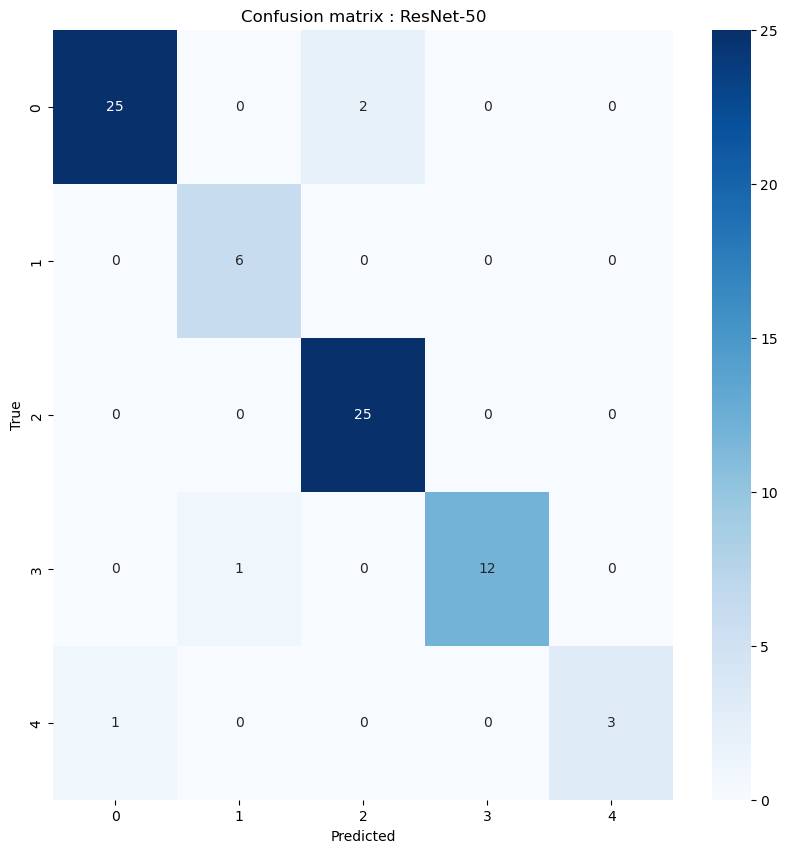

                      precision    recall  f1-score   support

Cercospora leaf spot       0.96      0.93      0.94        27
      Diseased Fruit       0.86      1.00      0.92         6
             Healthy       0.93      1.00      0.96        25
       Healthy Fruit       1.00      0.92      0.96        13
      Powdery Mildew       1.00      0.75      0.86         4

            accuracy                           0.95        75
           macro avg       0.95      0.92      0.93        75
        weighted avg       0.95      0.95      0.95        75



In [20]:
model=model_resNet50
y_pred = model.predict(test)
y_true = test.classes

# Convert predictions to class indices
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, new)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix : ResNet-50')
plt.show()

# classification report
report = classification_report(y_true, new, target_names=class_labels)
print(report)

In [ ]:
import pickle


with open('resnet50_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
model.save("NEW_RESNET50.h5")